In [49]:
import os
import getpass
import base64
import uuid
import io
import re
from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence.models import DocumentContentFormat, AnalyzeOutputOption
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pathlib import Path
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import AzureOpenAIEmbeddings
from langchain_core.output_parsers.string import StrOutputParser

In [33]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("DOC_INTELLIGENCE_KEY")
_set_env("AZURE_OPENAI_API_KEY")

In [65]:
import time

def document_layout_analysis(document_path: Path, figures_path: Path):
    figures_path.mkdir(parents=True, exist_ok=True)

    doc_intel_client = DocumentIntelligenceClient(
        endpoint="https://arthur-document-intelligence.cognitiveservices.azure.com/",
        credential=AzureKeyCredential(os.environ["DOC_INTELLIGENCE_KEY"])
    )

    start_time = time.time()
    with open(document_path, "rb") as f:
        poller = doc_intel_client.begin_analyze_document(
            "prebuilt-layout",
            body=f,
            output=[AnalyzeOutputOption.FIGURES],
            output_content_format=DocumentContentFormat.MARKDOWN
        )
    result = poller.result()

    end_time = time.time() - start_time
    print(f"Document {document_path.stem} converted in {end_time:.2f} seconds.")
    if result.figures:
        for figure in result.figures:
            response = doc_intel_client.get_analyze_result_figure(
                model_id=result.model_id, figure_id=figure.id, result_id=poller.details.get('operation_id')
            )
            file_path = Path(figures_path) / f"{figure.id}.png"
            with open(file_path, "wb") as writer:
                writer.writelines(response)
    
    return result

In [ ]:
pdf_names = ["wildfire", "spanned-table", "attention", "complex"]
for pdf in pdf_names:
    result = document_layout_analysis(Path(".") / f"{pdf}.pdf", Path("./images/docintel") / pdf)
    md_path = f"./markdown/docintel/{pdf}.md"
    with open(md_path, "w") as writer:
        writer.writelines(result.content)

Document wildfire converted in 10.47 seconds.
Document spanned-table converted in 13.40 seconds.
Document attention converted in 11.38 seconds.
Document complex converted in 29.42 seconds.


In [67]:
pdf_names = ["cj"]
for pdf in pdf_names:
    result = document_layout_analysis(Path(".") / f"{pdf}.pdf", Path("./images/docintel") / pdf)
    md_path = f"./markdown/docintel/{pdf}.md"
    with open(md_path, "w") as writer:
        writer.writelines(result.content)

Document cj converted in 31.04 seconds.


In [68]:
pdf_names = ["complex"]
for pdf in pdf_names:
    result = document_layout_analysis(Path(".") / f"{pdf}.pdf", Path("./images/docintel") / pdf)
    md_path = f"./markdown/docintel/{pdf}.md"
    with open(md_path, "w") as writer:
        writer.writelines(result.content)

Document complex converted in 24.51 seconds.


In [36]:
IMAGE_PATH="./images/docintel/wildfire"
DOC_PATH="./wildfire.pdf",

In [ ]:
result = document_layout_analysis(Path(DOC_PATH), Path(IMAGE_PATH))

In [43]:
MD_PATH = "./markdown/docintel/wildfire.md"
with open(MD_PATH, "w") as writer:
    writer.writelines(result.content)

In [70]:
def split_markdown(md: str):
    headers_to_split_on = [
        ("#", "Header 1"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on, strip_headers=False)
    md_header_splits = markdown_splitter.split_text(md)
    return md_header_splits

In [72]:
MD_PATH = "./markdown/docintel/cj.md"

with open(MD_PATH, "r") as reader:
    doc = reader.read()

splits = split_markdown(doc)

In [74]:
IMAGE_PATH = "./images/docintel/cj"

def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = AzureChatOpenAI(
        azure_deployment="gpt-4o",
        api_version="2024-08-01-preview",
        azure_endpoint="https://pdf-converter.openai.azure.com/",
        max_tokens=1024
    )

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".png"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries(IMAGE_PATH)

In [1]:
img_base64_documents = [Document(image) for image in img_base64_list]

NameError: name 'img_base64_list' is not defined

In [75]:
image_summaries

['Headshot of a young man wearing a light purple shirt, smiling softly, and posed against a neutral background with a circular frame.',
 '"EV/NTM Revenue Multiples from Jan 2015 to Oct 2023 showing High Growth, Mid Growth, and Low Growth Medians; peak around Nov 2020 and steady decline post Jan 2021, current values at 11.8x, 7.4x, and 3.9x respectively."',
 'Bar graph showing the "Overall Impact of Newspapers" on social media. The horizontal axis represents the percentage of social media engagement and the vertical axis lists newspaper names. The graph highlights newspapers like "Snowflake" and "Angelsfire" with the highest impact, while "Metro" is at the lower end. Marked benchmark line indicates median impact level.',
 'Graph illustrating the trends of Median EV/NTM Revenue/Growth Multiples, LT Average, and 10 Year Treasury rates from January 2015 to October 2023. The Median EV/Rev/Growth (dark blue line) and LT Average (light blue line) exhibit significant fluctuations, with a noted

In [76]:
child_text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name="gpt-4o",
    chunk_size=500,
    chunk_overlap=100
)

def create_multi_vector_retriever(
    vectorstore, texts, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    def add_texts(docs: list[Document]):
        doc_ids = [str(uuid.uuid4()) for _ in docs]
        sub_docs = []
        for i, doc in enumerate(docs):
            _id = doc_ids[i]
            _sub_docs = child_text_splitter.split_documents([doc])
            for _doc in _sub_docs:
                _doc.metadata[id_key] = _id
            sub_docs.extend(_sub_docs)
        retriever.vectorstore.add_documents(sub_docs)
        retriever.docstore.mset(list(zip(doc_ids, docs)))

    # Helper function to add documents to the vectorstore and docstore
    def add_images(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    add_texts(texts)
    if image_summaries:
        add_images(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog", embedding_function=AzureOpenAIEmbeddings(
        azure_deployment="text-embedding-3-large",
        api_version="2024-08-01-preview",
        azure_endpoint="https://pdf-converter.openai.azure.com/",
    )
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    splits,
    image_summaries,
    img_base64_list,
)

In [77]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/png;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = AzureChatOpenAI(
        temperature=0, 
        azure_deployment="gpt-4o",
        api_version="2024-08-01-preview",
        azure_endpoint="https://pdf-converter.openai.azure.com/",
        max_tokens=1024
    )

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

In [78]:
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [79]:
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.invoke(query, limit=6)
len(docs)

2

In [83]:
print(docs[0])

page_content='# Clouded Judgement 11.10.23 - OpenAI Updates + Datadog Gives the All-Clear?  
<figure>
</figure>  
JAMIN BALL
NOV 10, 2023  
35  
0 2  
Share  
Every week I'll provide updates on the latest trends in cloud software companies. Follow along to
stay up to date!  
Type your email ...  
Subscribe  
OpenAI Updates  
OpenAI had their big developer day this week, and I wanted to call out two key announcements
(and trends): increasing context windows and decreasing costs.  
When I think about the monetization of AI (and which "layers" monetize first) I've always
thought it would follow the below order, with each layer lagging the one that comes before it.  
1\. Raw silicon (chips like Nvidia bought in large quantities to build out infra to service
upcoming demand).  
2\. Model providers (OpenAI, Anthropic, etc as companies start building out AI).  
<!-- PageFooter="https://cloudedjudgement.substack.com/p/clouded-judgement-111023" -->
<!-- PageNumber="1/21" -->
<!-- PageBreak --> 


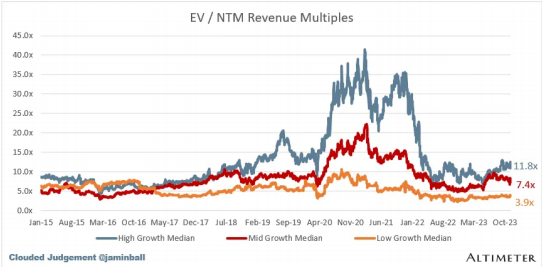

In [82]:
plt_img_base64(docs[1])

In [85]:
result = chain_multimodal_rag.invoke(query)
print(result)

Based on the provided data, here are the EV/NTM revenue multiples and NTM revenue growth rates for MongoDB, Cloudflare, and Datadog:

1. **MongoDB (MDB)**
   - **EV/NTM Revenue Multiple**: 14.6x
   - **NTM Revenue Growth**: 17%

2. **Cloudflare (NET)**
   - **EV/NTM Revenue Multiple**: 13.4x
   - **NTM Revenue Growth**: 28%

3. **Datadog (DDOG)**
   - **EV/NTM Revenue Multiple**: 13.1x
   - **NTM Revenue Growth**: 19%

These metrics indicate that all three companies are trading at high revenue multiples, reflecting strong growth expectations. Cloudflare has the highest NTM revenue growth rate among the three, which may justify its relatively high EV/NTM revenue multiple. MongoDB and Datadog also show robust growth, with Datadog having a slightly lower multiple compared to MongoDB, possibly due to its slightly higher growth rate.


In [58]:
query = "Compare structures burned between 2019 and 2020"
docs = retriever_multi_vector_img.invoke(query, limit=6)
len(docs)

4

In [63]:
print(docs[1])

page_content='## Wildfire Damages  
Wildfires may affect certain ecological resources
beneficially, but wildfires also may have devastating
impacts, especially for communities affected by wildfire
activity. Statistics showing the level of destruction a
wildfire caused can provide useful metrics to evaluate the
fire's effect. Such statistics may include acres burned or
impacted, lives lost (firefighters and civilians), and
structures (residential, commercial, and other) destroyed.
For example, in 2022, over 2,700 structures were burned in
wildfires; the majority of the damage occurred in California
(see Table 2).  
<table>
<caption>Table 2. Loss Statistics</caption>
<tr>
<th></th>
<th>2019</th>
<th>2020</th>
<th>2021</th>
<th>2022</th>
</tr>
<tr>
<td>Structures Burned</td>
<td>963</td>
<td>17,904</td>
<td>5,972</td>
<td>2,717</td>
</tr>
<tr>
<td>% Residences</td>
<td>46%</td>
<td>54%</td>
<td>60%</td>
<td>46%</td>
</tr>
</table>  
Source: NICC Wildland Fire Summary and Statistics annual

In [61]:
chain_multimodal_rag.invoke(query)

"Based on the provided data, there is a significant difference in the number of structures burned between 2019 and 2020. Here are the key points:\n\n1. **Structures Burned**:\n   - In 2019, 963 structures were burned.\n   - In 2020, 17,904 structures were burned.\n\n2. **Percentage of Residences**:\n   - In 2019, 46% of the structures burned were residences.\n   - In 2020, 54% of the structures burned were residences.\n\nThis indicates a dramatic increase in the number of structures burned from 2019 to 2020, with 2020 experiencing nearly 18 times more structures burned compared to 2019. The percentage of residences among the burned structures also increased, suggesting a higher impact on residential areas in 2020.\n\n### Investment Advice:\n\nGiven the substantial increase in wildfire damage, particularly in 2020, it would be prudent to consider investments in sectors related to wildfire prevention, mitigation, and recovery. Here are some potential areas for investment:\n\n1. **Wildfir